In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [2]:
# create variables for the BTC ticker and dates (as strings) for the timeframe to examine
ticker = 'BTC-USD'
# dates are Y-m-d format
start_date = '2022-01-01'
end_date = '2023-04-27'

In [3]:
# download the historical data using yfinance
df = yf.download(ticker, start=start_date, end=end_date)
df.reset_index(inplace=True)
# create a column for the mean price for each day, this will be used as the purchase price
df['Mean'] = (df['Open'] + df['Close']) / 2
# move the mean column
df.insert(4, 'Mean', df.pop('Mean'))
# round all the values to 2 decimals
df = df.round(2)

[*********************100%***********************]  1 of 1 completed


In [4]:
# convert dates to datetime format
start_date = dt.strptime(start_date, '%Y-%m-%d')
end_date = dt.strptime(end_date, '%Y-%m-%d')

In [5]:
def DCA_func(start_date, end_date, dollar_per_day, btc_df):
    '''
    This function calculates the cost basis for daily bitcoin
    purchases over a given time. This function uses the mean price 
    for the day as the buy price.
    
    Parameters
    ----------
    start_date : (datetime) in Y-m-d format
    end_date : (datetime) in Y-m-d format
    dollar_per_day : (int) dollar amount of BTC purchased per day
    btc_df : bitcoin price ticker dataframe

    Returns
    -------
    Pandas dataframe that includes the rolling cost basis over time
    with total dollars invested and total BTC purchased

    '''
    # add a column for the amount of BTC purchased for every day in the dataframe
    btc_df['BTC_Purchased'] = dollar_per_day / btc_df['Mean']
    
    # add a column for the running total invested
    total_invested = np.arange(dollar_per_day, dollar_per_day*len(btc_df.index) + 1, dollar_per_day)
    btc_df['Total_Dollars_Invested'] = total_invested
    
    # add a column for the running total BTC purchased
    btc_df['Total_BTC_Purchased'] = btc_df['BTC_Purchased'].cumsum()
    
    # calculate running cost basis
    btc_df['Cost_Basis'] = round(btc_df['Total_Dollars_Invested'] / btc_df['Total_BTC_Purchased'], 2)

    return btc_df

In [6]:
# create variable dollar amount invested per day
investment_per_day = 10

# get cost basis dataframe using DCA function
df = DCA_func(start_date, end_date, investment_per_day, df)

df.head()

,Date,Open,High,Low,Mean,Close,Adj Close,Volume,BTC_Purchased,Total_Dollars_Invested,Total_BTC_Purchased,Cost_Basis
0,2022-01-01,46311.75,47827.31,46288.48,46999.28,47686.81,47686.81,24582667004,0.000213,10,0.000213,46999.28
1,2022-01-02,47680.93,47881.41,46856.94,47513.07,47345.22,47345.22,27951569547,0.000210,20,0.000423,47254.78
2,2022-01-03,47343.54,47510.73,45835.96,46900.83,46458.12,46458.12,33071628362,0.000213,30,0.000636,47136.20
3,2022-01-04,46458.85,47406.55,45752.46,46178.21,45897.57,45897.57,42494677905,0.000217,40,0.000853,46893.00
4,2022-01-05,45899.36,46929.05,42798.22,44734.18,43569.00,43569.00,36851084859,0.000224,50,0.001077,46444.72


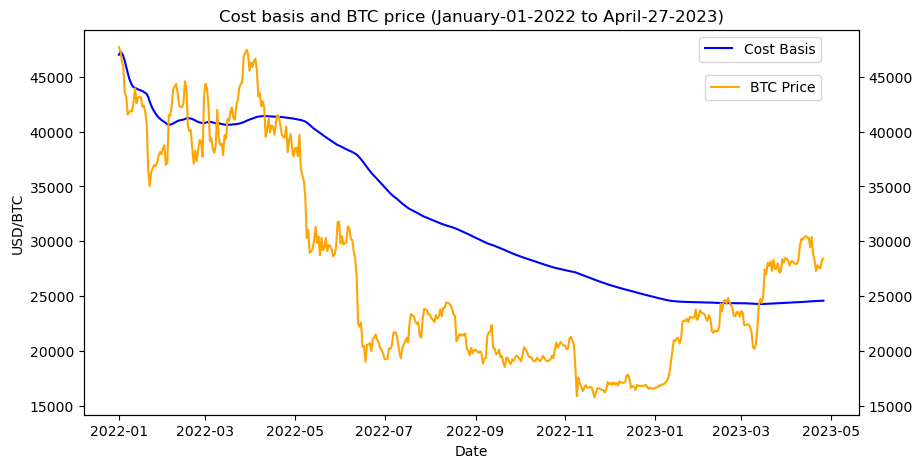

In [7]:
# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot the data on the first subplot
sns.lineplot(x='Date', y='Cost_Basis', data=df, ax=ax1, color='blue')
ax1.tick_params(axis='y', labelleft=True)
ax1.set_ylabel('USD/BTC')

# Plot the data on the second subplot
sns.lineplot(x='Date', y='Close', data=df, ax=ax2, color='orange')
ax2.tick_params(axis='y', labelright=True)
ax2.set_ylabel('') 

# Set x-axis label and title
ax1.set_xlabel('Date')
ax1.set_title(f'Cost basis and BTC price ({start_date:%B-%d-%Y} to {end_date:%B-%d-%Y})')

# Set the y-axis range to be equal on both subplots
ymin = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
ax1.set_ylim(bottom=ymin)
ax2.set_ylim(bottom=ymin)
ymax = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(top=ymax)
ax2.set_ylim(top=ymax)

# Add a legend for the cost basis and BTC price
ax1.plot([], [], color='blue', label='Cost Basis')
ax2.plot([], [], color='orange', label='BTC Price')
ax1.legend(loc='upper right', bbox_to_anchor=(0.96, 1.0))
ax2.legend(loc='upper right', bbox_to_anchor=(0.96, 0.9))

# Display the plot
plt.show()